In [108]:
import mglearn
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import datasets
from sklearn.decomposition import NMF
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from scipy import signal
import pandas as pd
import seaborn as sns

# Non-Negative Matrix Factorization (NMF)

- **Dimension reduction** technique
- NMF models are interpretable (unlike PCA)
- **GOAL**: to write each data point as a weighted sum of some components:

![title](img/nmf.png)

* both the **components and the coefficients to be >= 0**
* **MUST**: data where each feature is non-negative

#### Interpretable parts
-NMF expresses documents as combinations of topics (or "themes")
-NMF expresses images as combinations of patterns
-NMF expresses audio tracks as combinations of audio clips
-NMF can identify the original components that make up the combined data

#### NMF on synthetic data
* Since data has to be positive one can think of the non-negative components that are extracted as directions from (0, 0) toward the data. NMF on 2D data:

![title](img/nmf2.png)

* On the left (with 2 components), all the datapoints can be represented as a positive combination of the two components since no. of components = nr of features.
* If **n_components == n_features**: the algorithm chooses directions that point toward the extremes of the data.
* If **n_components == 1**: component that points toward the mean, as pointing there best explains the data.
* Components in NMF are <font color='red'>**NOT ordered**</font> and all components play **an equal role**.

## NMF on Face Recognition

* usually we want **n_components < n_features**.

Lets inspect how the number of components impacts how well the data can be reconstructed using NMF.

In [7]:
# data bunch object
people = datasets.fetch_lfw_people(min_faces_per_person=20, resize=0.7)

image_shape = people.images[0].shape

# limit ourselves with max 50 different images per person
mask = np.zeros(people.target.shape, dtype=np.bool)

for target in np.unique(people.target):
    mask[np.where(people.target == target)[0][:50]] = 1
    
X_people = people.data[mask]
y_people = people.target[mask]

# scale the grayscale values to be between 0 and 1
# instead of 0 and 255 for better numeric stability
X_people = X_people / 255.

X_train, X_test, y_train, y_test = train_test_split(X_people, y_people,
                                                   stratify=y_people,
                                                   random_state=0)

![title](img/nmf3.png)

* NMF has slightly worse reconstruction quality compared to PCA
* NMF not optimal for encoding but rather for finding interesting patterns within the data

Let’s try extracting only a few components (say, 15):

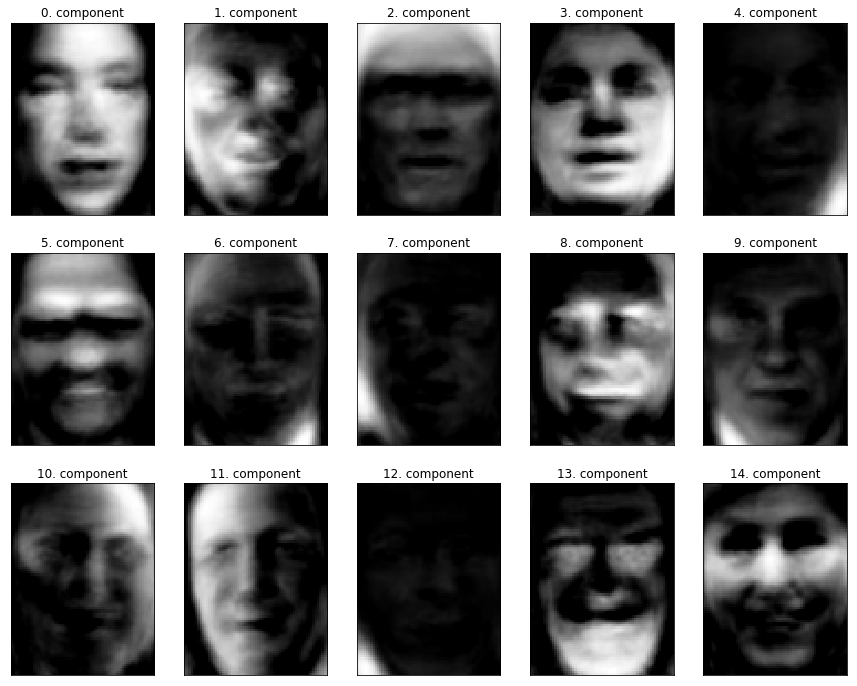

In [18]:
nmf = NMF(n_components=15, random_state=0)
nmf.fit(X_train)

X_train_nmf = nmf.transform(X_train)
X_test_nmf = nmf.transform(X_test)

# plotting the components
fix, axes = plt.subplots(3, 5, figsize=(15, 12),
                         subplot_kw={'xticks': (), 'yticks': ()})

for i, (component, ax) in enumerate(zip(nmf.components_, axes.ravel())):
    ax.imshow(component.reshape(image_shape))
    ax.set_title("{}. component".format(i))
plt.set_cmap('Greys_r')
plt.show()

* since the NMF components are all positive, they resemble faces much more than PCA did
* component number 8 is looking slightly to the left (our perspective), let's see which faces the NMF identifies based on component 8:

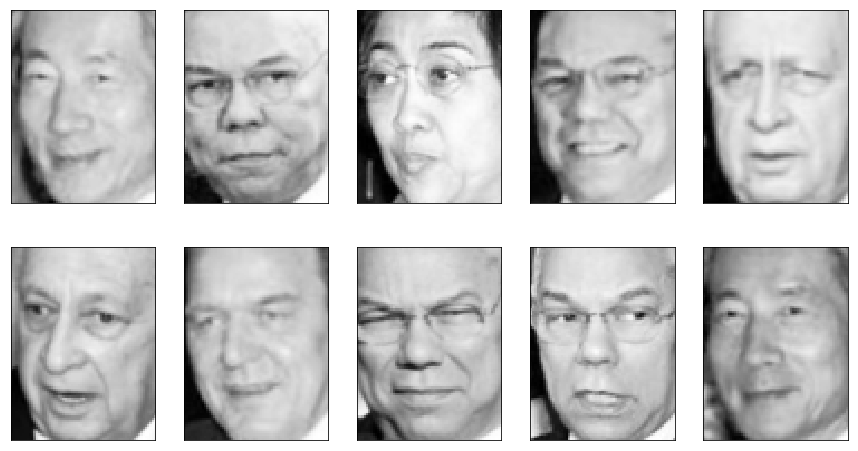

In [31]:
compn = 8
# sort by 3rd component, plot first 10 images
inds = np.argsort(X_train_nmf[:, compn])[::-1]
fig, axes = plt.subplots(2, 5, figsize=(15, 8), 
                         subplot_kw={'xticks': (), 'yticks': ()})
for i, (ind, ax) in enumerate(zip(inds, axes.ravel())):
    ax.imshow(X_train[ind].reshape(image_shape))
plt.show()

* all people tend to look to the left also!
* extracting patterns like these works best for data with additive structure, including **audio, gene expression, and text data**.

## NMF on Signal Recognition

An example on synthetic data, provied by mglearn!!

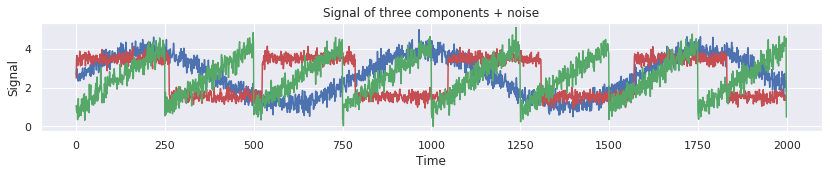

In [136]:
# making the signal
def make_signals():
    rng = np.random.RandomState(42)
    n_samples = 2000
    time = np.linspace(0, 8, n_samples)
    
    # create three signals
    s1 = np.sin(2 * time) # sinusoidial
    s2 = np.sign(np.sin(3 * time)) # square signal.
    s3 = signal.sawtooth(2 * np.pi * time) # sawtooth signal
    
    # concat signals & add noise
    S = np.c_[s1, s2, s3]
    S += 0.2 * rng.normal(size=S.shape)
    
    # standardize data
    S /= S.std(axis=0)
    S -= S.min()
    return S

# signal
S = make_signals()
plt.figure(figsize=(14, 2))
plt.plot(S[:,0], '-', color='b')
plt.plot(S[:,1], '-', color='r')
plt.plot(S[:,2], '-', color='g')
plt.xlabel('Time')
plt.ylabel('Signal')
plt.title('Signal of three components + noise')
plt.show()

* We assume that we have many different ways to observe the mixture (say 100 measurement devices), each of which provides us with a series of measurements:

In [137]:
# mix data into a 100-dimensional state
A = np.random.RandomState(0).uniform(size=(100, 3))

# dot product of 2 arrays
X = np.dot(S, A.T) 

print("Shape of measurements: {}".format(X.shape))

Shape of measurements: (2000, 100)


In [138]:
# use NMF to recover the signals
nmf = NMF(n_components=3, random_state=42)
S_nmf = nmf.fit_transform(X)

print('Recovered signal shape: {}'.format(S_nmf.shape))

# by comparison also create PCA data
pca = PCA(n_components=3)
S_pca = pca.fit_transform(X)

Recovered signal shape: (2000, 3)


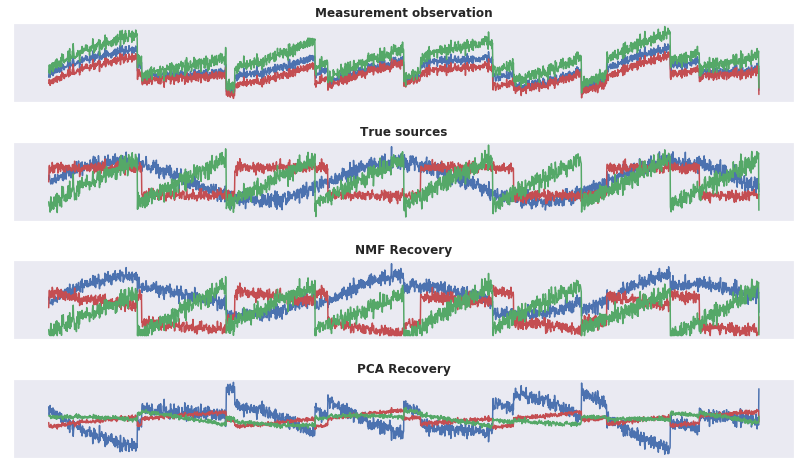

In [139]:
models = [X, S, S_nmf, S_pca]
names = ['Measurement observation', 'True sources', 'NMF Recovery', 'PCA Recovery']
# plotting the models

fix, axes = plt.subplots(4,1, figsize=(14,8), gridspec_kw={'hspace':.5},
                      subplot_kw={'xticks': (), 'yticks': ()})

for model, name, ax in zip(models, names, axes):
    ax.set_title(name, weight='bold')
    ax.plot(model[:,0], '-', c='b')
    ax.plot(model[:,1], '-', c='r')
    ax.plot(model[:,2], '-', c='g')
plt.show()

* NMF did a reasonable job of discovering the original sources
* PCA failed
* the ordering of the NMF components is the same as in the original signal (see the shading of the three curves), but this is purely accidental.

## NMF on Led Number Recogniton

* decompose grayscale images into their commonly occurring patterns. 
* xplore the image dataset and see how it is encoded as an array. 
* 100 images given as a 2D array samples, where each row represents a single 13x8 image. 
* The images in your dataset are pictures of a LED digital display.

In [98]:
# original data
led = pd.read_csv('data/lcd-digits.csv', header=None, dtype=np.int32)
# convert to numpy array
led_samples = led.values
# check the shape info
print('Shape of ndarray: {}'.format(led_samples.shape))
print('\nTotal pixels per image = 13 x 8 = {}'.format(8*13))

Shape of ndarray: (100, 104)

Total pixels per image = 13 x 8 = 104


Raw array:
[0 0 0 0 0 0 0 0 0 0 1 1 1 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0
 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0
 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]

Reshaped array:
[[0 0 0 0 0 0 0 0]
 [0 0 1 1 1 1 0 0]
 [0 0 0 0 0 0 1 0]
 [0 0 0 0 0 0 1 0]
 [0 0 0 0 0 0 1 0]
 [0 0 0 0 0 0 1 0]
 [0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 0]
 [0 0 0 0 0 0 1 0]
 [0 0 0 0 0 0 1 0]
 [0 0 0 0 0 0 1 0]
 [0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0]]


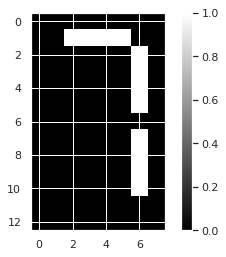

In [110]:
# original first image
print('Raw array:\n{}'.format(led_samples[0,:]))

bitmap = led_samples[0,:].reshape(13, 8)

# reshaped first image
print('\nReshaped array:\n{}'.format(bitmap))

# imshow the bitmap
sns.set()
plt.imshow(bitmap, cmap='gray', interpolation='nearest')
plt.colorbar()
plt.show()

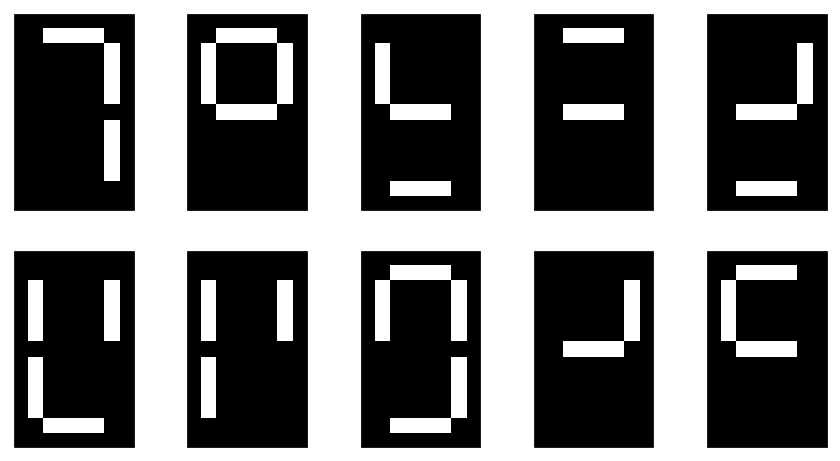

In [118]:
# plot first 10 images
ims = led_samples[:10,:]

fix, axes = plt.subplots(2, 5, figsize=(15, 8), subplot_kw={'xticks': (),
                                          'yticks': ()})

for img, ax in zip(ims, axes.ravel()):
    bitm = img.reshape(13,8)
    ax.imshow(bitm, cmap='gray', interpolation='nearest')
plt.show()

Lets distinguish all 7 possible components that make up a digital number

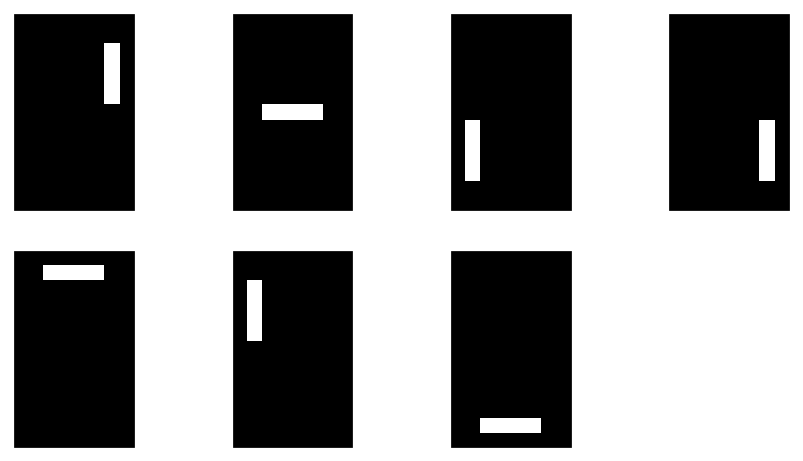

In [143]:
# non-negative matrix factorization
nmf = NMF(n_components=7)
features = nmf.fit_transform(led_samples)

fix, axes = plt.subplots(2,4, figsize=(15,8), subplot_kw={'xticks':(),
                                                         'yticks':()})


for component, ax in zip(nmf.components_, axes.ravel()):
    
    bitm = component.reshape(13, 8)
    ax.imshow(bitm, cmap='gray', interpolation='nearest')
fix.delaxes(ax=axes[1, 3])
plt.show()